In [15]:
%matplotlib inline
import flopy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pathlib as pl
import pandas as pd
import sys

In [16]:
sys.path.append("../common")
from liss_settings import cx, cx_provider, extent, boxx, boxy, extentmax, fig_ext, transparent

In [17]:
units = "mm"
conversion_factor = 1.0
if units == "mm":
    conversion_factor = 25.4
total_key = f"total_{units}"

## Load base MODFLOW model

In [18]:
ws = "../modflow/greenport_chd/base/"
sim = flopy.mf6.MFSimulation.load(sim_ws=ws, verbosity_level=0)

gwf = sim.get_model()

nghb = gwf.ghb.stress_period_data.get_dataframe()[0].shape[0]
area = nghb * 500.0 * 500.0

## Load the coastal boundary observation data

In [19]:
sim_dirs = ["run_01.00D", "run_08.00H", "run_04.00H", "run_02.00H", "run_01.00H", "run_15.00M"]

In [20]:
sim_dict = {value: {"ws": pl.Path(f"../modflow/greenport_chd/{value}")} for value in sim_dirs}
sim_dict

{'run_01.00D': {'ws': WindowsPath('../modflow/greenport_chd/run_01.00D')},
 'run_08.00H': {'ws': WindowsPath('../modflow/greenport_chd/run_08.00H')},
 'run_04.00H': {'ws': WindowsPath('../modflow/greenport_chd/run_04.00H')},
 'run_02.00H': {'ws': WindowsPath('../modflow/greenport_chd/run_02.00H')},
 'run_01.00H': {'ws': WindowsPath('../modflow/greenport_chd/run_01.00H')},
 'run_15.00M': {'ws': WindowsPath('../modflow/greenport_chd/run_15.00M')}}

In [ ]:
# for key, value in sim_dict.items():
#     obs_path = value["ws"] / "green2010_v3.ghb.obs.csv" # This file only exists here "..\modflow\greenport500ft\run_01.00H"
#     df = flopy.utils.Mf6Obs(obs_path).get_dataframe(start_datetime="1-1-2010")
#     df["delt"] = df["totim"].diff()
#     df.loc[df["delt"].isnull(), "delt"] = df["delt"].iloc[1]
#     df.drop("totim", axis=1, inplace=True)
#     df["TOTAL"] = 0.0
#     for col_name in ("SOUND", "INNER", "PECONIC"): # these do not exist 
#         df["TOTAL"] += -conversion_factor * 12.0 * df[col_name] / area
        
#     df["CUM_TOTAL"] = df["TOTAL"].cumsum() * df['delt']
#     df["ZERO"] = 0.
#     df.drop("delt", axis=1, inplace=True)
#     sim_dict[key]["ntimes"] = df.shape[0]
#     sim_dict[key]["df"] = df.copy()
#     sim_dict[key][total_key] = df["CUM_TOTAL"].iloc[-1]

In [27]:
for key, value in sim_dict.items():
    obs_path = value["ws"] / "gwf.ghb.obs.csv"

    df = flopy.utils.Mf6Obs(obs_path).get_dataframe(start_datetime="1-1-2010")
    df["delt"] = df["totim"].diff()
    df.loc[df["delt"].isnull(), "delt"] = df["delt"].iloc[1]
    df.drop("totim", axis=1, inplace=True)
    df["TOTAL"] = 0.0
    for col_name in ["INNER"]: # 
        df["TOTAL"] += -conversion_factor * 12.0 * df[col_name] / area
        
    df["CUM_TOTAL"] = df["TOTAL"].cumsum() * df['delt']
    df["ZERO"] = 0.
    df.drop("delt", axis=1, inplace=True)
    sim_dict[key]["ntimes"] = df.shape[0]
    sim_dict[key]["df"] = df.copy()
    sim_dict[key][total_key] = df["CUM_TOTAL"].iloc[-1]

In [ ]:
obs_path
df

## Plot the coastal exchange

In [29]:
ws = pl.Path("figures")
ws.mkdir(exist_ok=True, parents=True)

In [30]:
labels = [value.split(sep="_")[1] for value in sim_dirs]
for idx, label in enumerate(labels):
    s = f"{float(label[:5]):>2.0f}" + " " + label[-1]
    if s.endswith(" D"):
        s = s.replace(" D", " Day ")
    elif s.endswith(" H"):
        s = s.replace(" H", " Hour")
    elif s.endswith(" M"):
        s = s.replace(" M", " Min.")
    labels[idx] = s    
labels

[' 1 Day ', ' 8 Hour', ' 4 Hour', ' 2 Hour', ' 1 Hour', '15 Min.']

In [31]:
line_styles = ["-", "--", "-.", ":", (0, (3, 10, 1, 10, 1, 10)), (0, (3, 1, 1, 1, 1, 1))]

In [32]:
colors = [value for key, value in mcolors.TABLEAU_COLORS.items()]

In [33]:
cum_labels = []
for idx, value in enumerate(sim_dirs):
    total_flux = sim_dict[value][total_key]
    cum_labels.append(f"{labels[idx]} ({total_flux:5.2f} {units})")
cum_labels


[' 1 Day  (190.96 mm)',
 ' 8 Hour (221.93 mm)',
 ' 4 Hour (221.36 mm)',
 ' 2 Hour (219.64 mm)',
 ' 1 Hour (219.36 mm)',
 '15 Min. (219.16 mm)']

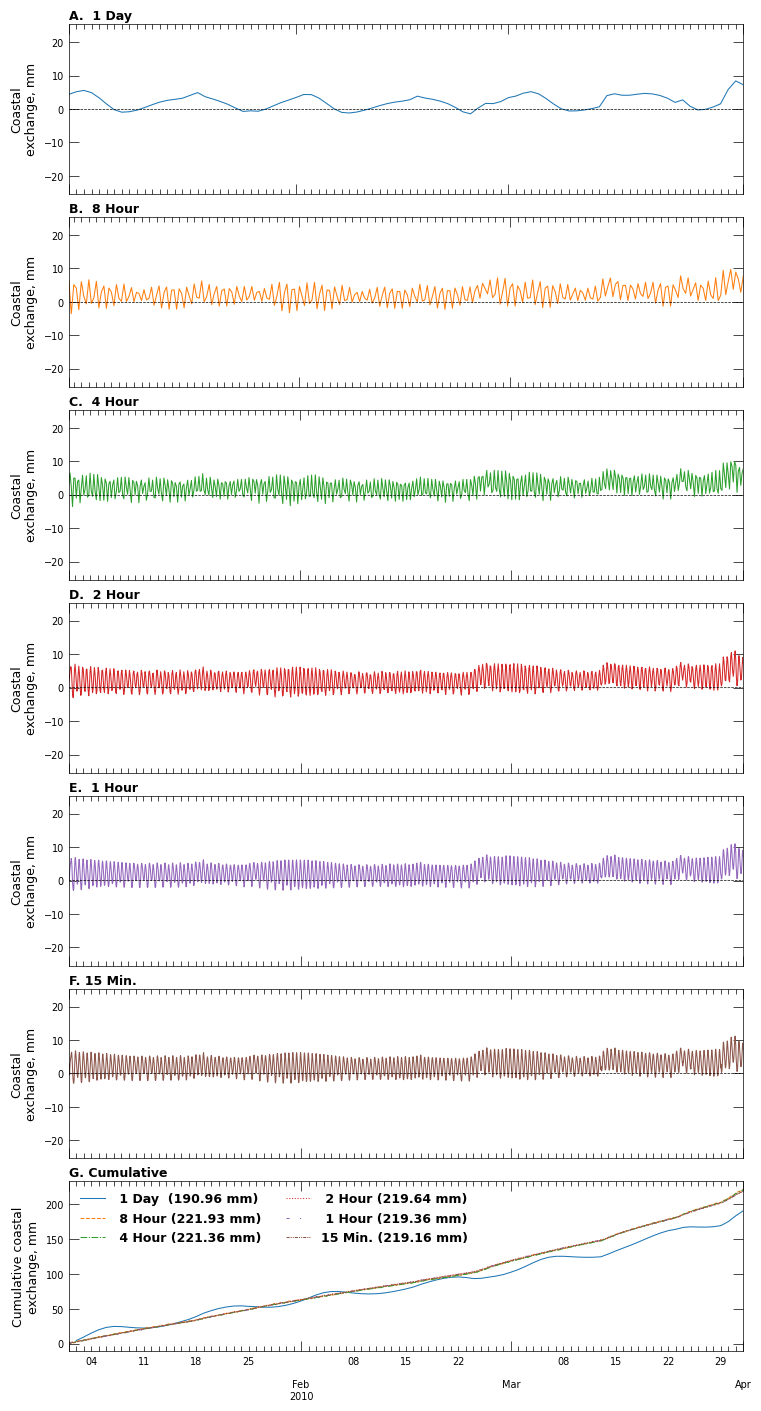

In [34]:
with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(
        ncols=1,
        nrows=len(labels) + 1,
        layout="constrained",
        figsize=(7.5, 2 * (len(labels) + 1)),
        )
    for idx in range(len(labels)):
        ax = axs[idx]
        ax.set_ylim(-1 * conversion_factor, 1 * conversion_factor)
        df = sim_dict[sim_dirs[idx]]["df"]
        df["TOTAL"].plot(ax=ax, lw=0.75, ls="-", color=colors[idx], sharex=True)
        df["ZERO"].plot(ax=ax, lw=0.5, ls="--", color="black", sharex=True)
        ax.set_ylabel(f"Coastal\nexchange, {units}")
        ax.set_xlabel("")
        flopy.plot.styles.heading(ax, idx=idx, heading=labels[idx])

    ax = axs[-1]
    ax.set_ylim(0, 15 * conversion_factor)
    for idx, value in enumerate(sim_dirs):
        sim_dict[value]["df"]["CUM_TOTAL"].plot(ax=ax, lw=0.75, ls=line_styles[idx], color=colors[idx], label=cum_labels[idx])
    ax.set_ylabel(f"Cumulative coastal\nexchange, {units}")
    ax.set_xlabel("")
    flopy.plot.styles.heading(ax, idx=len(labels), heading="Cumulative")
    
    leg = flopy.plot.styles.graph_legend(ax=ax, loc="upper left", title="none", ncol=2)

    fig.savefig(ws / f"coastal_flux_summary{fig_ext}", dpi=300, transparent=transparent)


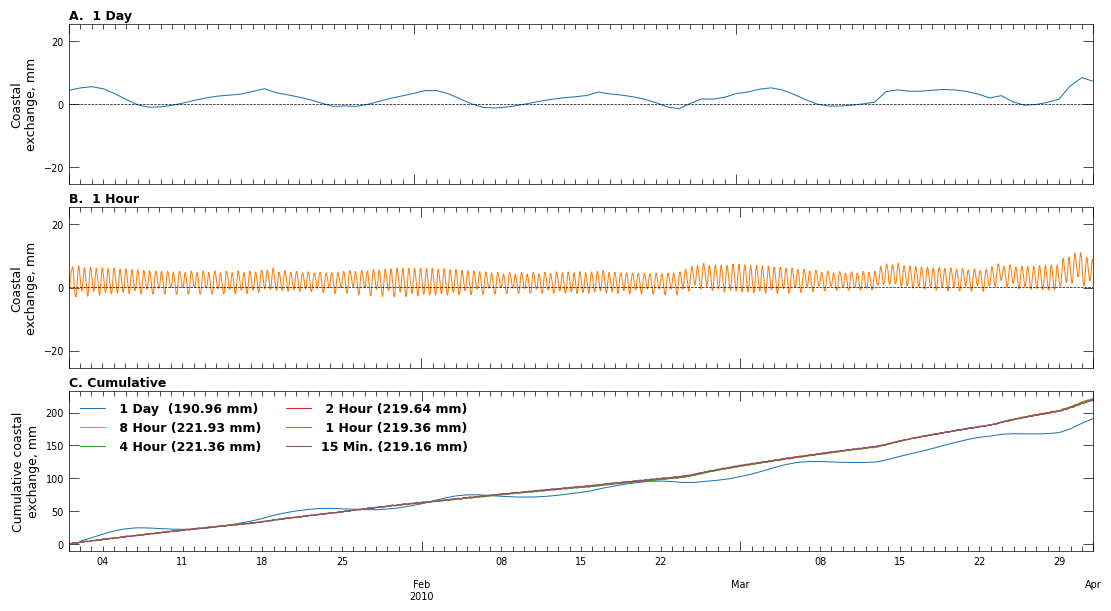

In [35]:
plot_sim_dirs = [sim_dirs[0], sim_dirs[-2]]
plot_labels = [labels[0], labels[-2]]

with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(
        ncols=1,
        nrows=len(plot_labels) + 1,
        layout="constrained",
        figsize=(11, 2 * (len(plot_labels) + 1)),
        )
    for idx in range(len(plot_labels)):
        ax = axs[idx]
        ax.set_ylim(-1 * conversion_factor, 1 * conversion_factor)
        df = sim_dict[plot_sim_dirs[idx]]["df"]
        df["TOTAL"].plot(ax=ax, lw=0.75, ls="-", color=colors[idx], sharex=True)
        df["ZERO"].plot(ax=ax, lw=0.5, ls="--", color="black", sharex=True)
        ax.set_ylabel(f"Coastal\nexchange, {units}")
        ax.set_xlabel("")
        flopy.plot.styles.heading(ax, idx=idx, heading=plot_labels[idx])

    ax = axs[-1]
    ax.set_ylim(0, 15 * conversion_factor)
    for idx, value in enumerate(sim_dirs):
        sim_dict[value]["df"]["CUM_TOTAL"].plot(ax=ax, lw=0.75, color=colors[idx], label=cum_labels[idx])
    ax.set_ylabel(f"Cumulative coastal\nexchange, {units}")
    ax.set_xlabel("")
    flopy.plot.styles.heading(ax, idx=len(plot_labels), heading="Cumulative")
    
    leg = flopy.plot.styles.graph_legend(ax=ax, loc="upper left", title="none", ncol=2)

    fig.savefig(ws / f"coastal_flux_poster_summary{fig_ext}", dpi=300, transparent=transparent)

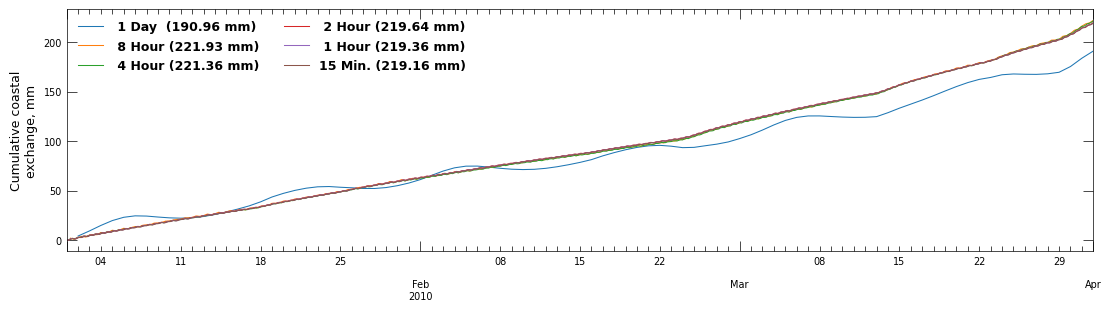

In [36]:
with flopy.plot.styles.USGSMap():
    fig, ax = plt.subplots(
        ncols=1,
        nrows=1,
        layout="constrained",
        figsize=(11, 3),
        )

    ax.set_ylim(0, 15 * conversion_factor)
    for idx, value in enumerate(sim_dirs):
        sim_dict[value]["df"]["CUM_TOTAL"].plot(ax=ax, lw=0.75, color=colors[idx], label=cum_labels[idx])
    ax.set_ylabel(f"Cumulative coastal\nexchange, {units}")
    ax.set_xlabel("")
    
    leg = flopy.plot.styles.graph_legend(ax=ax, loc="upper left", title="none", ncol=2)

    fig.savefig(ws / f"coastal_cumulative_flux{fig_ext}", dpi=300, transparent=transparent)